<a href="https://colab.research.google.com/github/gnidetsanna/python_for_ML_tasks/blob/main/HW_NLP_Classification_Hnidets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!unzip drive/MyDrive/tweet_sentiment_train.csv.zip -d drive/MyDrive/tweet_data

Archive:  drive/MyDrive/tweet_sentiment_train.csv.zip
  inflating: drive/MyDrive/tweet_data/train.csv  


# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("drive/MyDrive/tweet_data/train.csv")
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [13]:
display(train_df.head())

display(train_df.describe())

display(train_df.dtypes)

display(train_df[train_df.isna().any(axis=1)])

train_df = train_df.dropna()
display(train_df.isna().any())

train_df = train_df.reset_index()

train_df = train_df.drop(columns=["index"])

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


,0
textID,object
text,object
selected_text,object
sentiment,object


,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


,0
textID,False
text,False
selected_text,False
sentiment,False


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



array(['neutral', 'negative', 'positive'], dtype=object)

,proportion
sentiment,
neutral,40.454876
positive,31.229985
negative,28.315138


Description of charachters amount in DF


,text
count,27480.000000
mean,68.330022
std,35.603870
min,3.000000
25%,39.000000
50%,64.000000
75%,97.000000
max,141.000000


Description of words/symbols amount in DF


,text
count,27480.000000
mean,13.779913
std,7.169690
min,1.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,101.000000


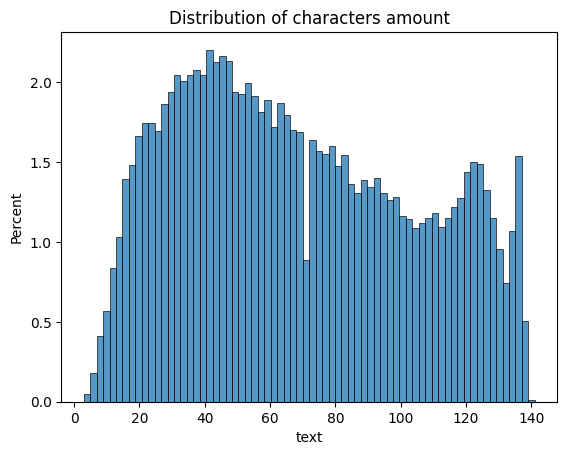

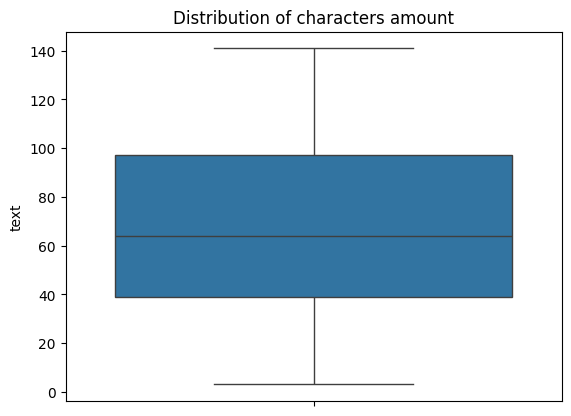

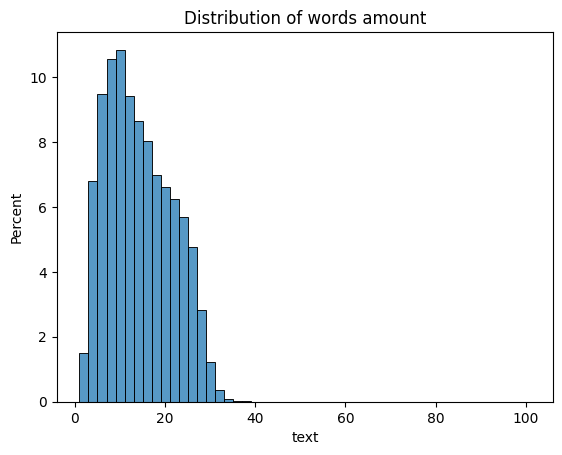

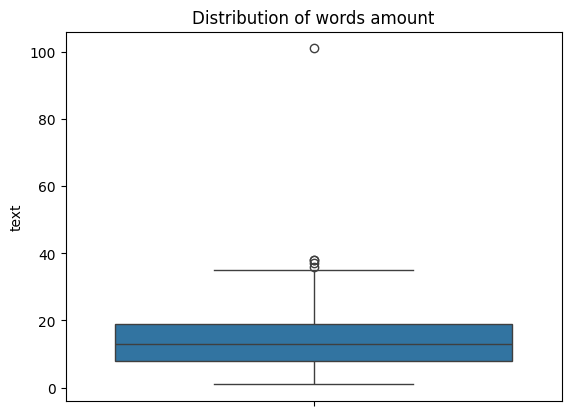

In [14]:
display(train_df["sentiment"].unique())

display(train_df["sentiment"].value_counts(normalize=True) * 100)

print("Description of charachters amount in DF")
display(train_df["text"].str.len().describe())
print("Description of words/symbols amount in DF")
display(train_df["text"].str.split(" ").apply(len).describe())

plt.title("Distribution of characters amount")
sns.histplot(train_df["text"].str.len(), stat="percent", bins=70)
plt.show()

plt.title("Distribution of characters amount")
sns.boxplot(train_df["text"].str.len())
plt.show()

plt.title("Distribution of words amount")
sns.histplot(train_df["text"].str.split(" ").apply(len), stat="percent",  bins=50)
plt.show()

plt.title("Distribution of words amount")
sns.boxplot(train_df["text"].str.split(" ").apply(len))
plt.show()

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
e_stopwords = stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in e_stopwords]

In [24]:

sent_detector = PunktSentenceTokenizer()
stemmer = SnowballStemmer(language='english')

train_df["tokens"] = train_df["text"].apply(lambda x: word_tokenize(x))
train_df["tokens"] = train_df["tokens"].apply(lambda x: remove_stopwords(x))
train_df["tokens"] = train_df["tokens"].apply(lambda x: [stemmer.stem(word) for word in x])

train_df["tokens_text"] = train_df["tokens"].apply(lambda x: " ".join(x))

In [25]:
raw_vect = CountVectorizer()

raw_vect_fit = raw_vect.fit(train_df["tokens_text"])

len(raw_vect_fit.get_feature_names_out())

21748

In [27]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=word_tokenize,
                             stop_words=e_stopwords,
                             max_features=5000)

In [28]:

%%time
vectorizer.fit(train_df["text"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


CPU times: user 7.77 s, sys: 3.36 ms, total: 7.78 s
Wall time: 10.3 s


CountVectorizer(max_features=5000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function word_tokenize at 0x7b81e5670b80>)

In [29]:

vectorizer.get_feature_names_out()[1000:1020]

array(['cobra', 'cocktail', 'cocktails', 'code', 'coding', 'coffee',
       'coincidence', 'coke', 'cold', 'coldplay', 'colds', 'colin',
       'colleagues', 'collect', 'collection', 'college', 'color',
       'colorado', 'colour', 'com'], dtype=object)

In [30]:

vectors = vectorizer.transform(train_df["text"])

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [32]:
from sklearn.model_selection import train_test_split

X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    vectorizer.transform(train_df["text"]),
    train_df["sentiment"],
    test_size=0.2,
    random_state=42
)

def encode_sentiment(sentiment):
    if sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    else:
        return 0

y_train = y_train.apply(encode_sentiment)
y_test = y_test.apply(encode_sentiment)

In [33]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train_bow, y_train)
dtest_reg = xgb.DMatrix(X_test_bow, y_test)

In [34]:
params = {"objective": "multi:softmax", "num_class": 3,"device": "cuda"}

n = 500
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:16:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:16:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [35]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(dtest_reg)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(y_test, y_pred))


Accuracy: 70.72%
              precision    recall  f1-score   support

           0       0.74      0.59      0.65      1572
           1       0.65      0.77      0.71      2236
           2       0.77      0.74      0.75      1688

    accuracy                           0.71      5496
   macro avg       0.72      0.70      0.70      5496
weighted avg       0.71      0.71      0.71      5496



In [36]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_bow, y_train)

# Прогнозування на тестових даних
y_pred = log_reg_model.predict(X_test_bow)

# Оцінка точності моделі
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Вивід звіту про класифікацію
print(classification_report(y_test, y_pred))

Accuracy: 0.6864992721979621
              precision    recall  f1-score   support

           0       0.69      0.60      0.65      1572
           1       0.64      0.72      0.68      2236
           2       0.76      0.71      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ВИсновок

З XGboost достатньо хороше покриття

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [37]:

importance_weight = model.get_score(importance_type='weight')
importance_gain = model.get_score(importance_type='gain')
importance_cover = model.get_score(importance_type='cover')

print("Feature importance by weight:", importance_weight)
print("Feature importance by gain:", importance_gain)
print("Feature importance by cover:", importance_cover)

#we will use gain in this case

sorted_importance_gain = sorted(importance_gain.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 most important features
top_10_features = sorted_importance_gain[:10]
print("Top 10 features by gain:", top_10_features)

feature_names = [i[0] for i in top_10_features]
feature_names = [name[1:] for name in feature_names]
feature_names = [int(name) for name in feature_names]

print(vectorizer.get_feature_names_out()[feature_names])

Feature importance by weight: {'f0': 1551.0, 'f1': 37.0, 'f2': 13.0, 'f4': 58.0, 'f5': 44.0, 'f6': 3.0, 'f14': 4.0, 'f16': 1.0, 'f20': 43.0, 'f21': 47.0, 'f22': 179.0, 'f23': 6.0, 'f24': 1190.0, 'f25': 76.0, 'f30': 1874.0, 'f31': 197.0, 'f32': 516.0, 'f33': 35.0, 'f34': 6.0, 'f35': 1.0, 'f36': 5.0, 'f37': 1.0, 'f39': 6.0, 'f42': 5.0, 'f45': 8.0, 'f48': 3.0, 'f51': 2.0, 'f59': 2.0, 'f65': 2.0, 'f74': 69.0, 'f87': 1.0, 'f92': 1.0, 'f93': 3.0, 'f94': 1.0, 'f98': 23.0, 'f102': 1.0, 'f103': 2.0, 'f105': 4.0, 'f108': 1.0, 'f109': 4.0, 'f110': 13.0, 'f114': 5.0, 'f115': 12.0, 'f117': 3.0, 'f118': 1.0, 'f124': 2.0, 'f125': 3.0, 'f127': 3.0, 'f128': 5.0, 'f130': 1.0, 'f132': 3.0, 'f134': 2.0, 'f135': 1.0, 'f143': 147.0, 'f144': 5.0, 'f145': 15.0, 'f146': 22.0, 'f147': 10.0, 'f148': 2.0, 'f152': 3.0, 'f153': 314.0, 'f154': 6.0, 'f155': 7.0, 'f157': 7.0, 'f158': 1.0, 'f165': 4.0, 'f168': 8.0, 'f175': 1427.0, 'f177': 1.0, 'f178': 2.0, 'f185': 1.0, 'f189': 2.0, 'f194': 6.0, 'f195': 5.0, 'f196': 4.0

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [39]:
tfid_vectorizer = TfidfVectorizer(lowercase=True,
                             tokenizer=word_tokenize,
                             stop_words=e_stopwords,
                             max_features=5000)

tfid_vectorizer.fit(train_df["text"])

tfid_vectors = tfid_vectorizer.transform(train_df["text"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [41]:

train_indexes = y_train.index
test_indexes = y_test.index

X_train_tfid = tfid_vectors[train_indexes]
X_test_tfid = tfid_vectors[test_indexes]

In [42]:
dtrain_reg = xgb.DMatrix(X_train_tfid, y_train)
dtest_reg = xgb.DMatrix(X_test_tfid, y_test)


In [43]:
# Define hyperparameters
params = {"objective": "multi:softprob", "num_class": 3,"device": "cuda", "eval_metric": "auc"}

n = 600
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:25:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [44]:


y_pred_proba = model.predict(dtest_reg)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 69.80%
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      1572
           1       0.64      0.75      0.69      2236
           2       0.77      0.72      0.74      1688

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496



In [45]:
mistakes = y_test != y_pred
mistakes_df = train_df.loc[mistakes.index]

mistakes_df

,textID,text,selected_text,sentiment,tokens,tokens_text
1588,6c5505a37c,Enjoy! Family trumps everything,Enjoy! Family trumps everything,positive,"[enjoy, !, famili, trump, everyth]",enjoy ! famili trump everyth
10413,126b1e6a22,--of them kinda turns me off of it all. And ...,kinda turns me off,negative,"[--, kinda, turn, ., buy, dig, deeper, hole, ,...","-- kinda turn . buy dig deeper hole , etc . ; ;"
6561,5bc4e623c4,Clive it`s my birthday pat me http://apps.fac...,Clive it`s my birthday pat me,neutral,"[clive, `, birthday, pat, http, :, //apps.face...",clive ` birthday pat http : //apps.facebook.co...
2602,984d753104,congrats hey,congrats,positive,"[congrat, hey]",congrat hey
4003,8a79072ca2,is texting,is texting,neutral,[text],text
...,...,...,...,...,...,...
12295,687aee2f7e,Just investigated whether I could change my u...,Just investigated whether I could change my us...,neutral,"[investig, whether, could, chang, usernam, erm...",investig whether could chang usernam ermintrud...
616,a82816a060,no one I know likes boiled peanuts t.,no one I know likes boiled peanuts t.,neutral,"[one, know, like, boil, peanut, .]",one know like boil peanut .
4504,f1f588a9bb,awww ) where`d you get that? hugh is so thin....,awww ) where`d you get that? hugh is so thin. ...,neutral,"[awww, ), `, get, ?, hugh, thin, ., trace, wol...",awww ) ` get ? hugh thin . trace wolverin yet ...
14491,4cca6419e7,Im craving some cinnamon toast crunch. Why is ...,so cold today!!,negative,"[im, crave, cinnamon, toast, crunch, ., cold, ...",im crave cinnamon toast crunch . cold today ! !


### Висновок

1. Видалення URL-адрес, зайвих символів і додаткова нормалізація тексту.
2. Використання більш складних методів представлення тексту, таких як TF-IDF або word embeddings (наприклад, Word2Vec або GloVe), що дозволить краще відобразити семантичну інформацію текст
3. Використання крос-валідованого підбору гіперпараметрів (GridSearchCV або RandomizedSearchCV) може покращити параметри моделі та її узгодженість.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model